In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import copy
import pickle as pickle
from tqdm import tqdm_notebook as tqdm


In [2]:
train = pd.read_csv('/home/dilraj/Desktop/mnist_train.csv', header=None)
train = train.values
train = train.T
print(train.shape)
print('')

test = pd.read_csv('/home/dilraj/Desktop/mnist_test.csv', header=None)
test = test.values
test = test.T
print(test.shape)


(785, 60000)

(785, 10000)


4
(784,)
(28, 28)


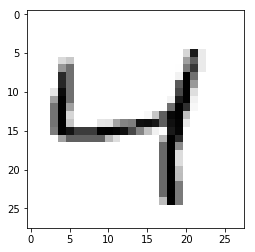

0
(784,)
(28, 28)


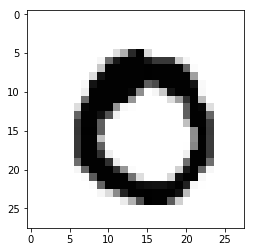

In [3]:
#plot 3rd and 57th training example
single = train[:, 2]
print(single[0])
single = single[1:]
print(single.shape)
single_image = single.reshape(28, 28)
print(single_image.shape)
plt.imshow(single_image, cmap='Greys')
plt.show()

single = train[:, 56]
print(single[0])
single = single[1:]
print(single.shape)
single_image = single.reshape(28, 28)
print(single_image.shape)
plt.imshow(single_image, cmap='Greys')
plt.show()


In [4]:
#separate labels and data
train_labels = train[0]
m = train_labels.shape[0]
print(train_labels.reshape(1, train_labels.shape[0]))
temp = tf.constant(10, name='temp')
train_labels_temp = tf.one_hot(train_labels, temp, axis=0)
session = tf.Session()
train_labels = session.run(train_labels_temp)
session.close()
print(train_labels)
print(train_labels.shape)
print('')
train_data = train[1:, :]
print(train_data)
print(train_data.shape)
print('')

test_labels = test[0]
print(test_labels.reshape(1, test_labels.shape[0]))
temp = tf.constant(10, name='temp')
test_labels_temp = tf.one_hot(test_labels, temp, axis=0)
session = tf.Session()
test_labels = session.run(test_labels_temp)
session.close()
print(test_labels)
print(test_labels.shape)
print('')
test_data = test[1:, :]
print(test_data)
print(test_data.shape)


[[5 0 4 ..., 5 6 8]]
[[ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(10, 60000)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
(784, 60000)

[[7 2 1 ..., 4 5 6]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(10, 10000)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
(784, 10000)


In [5]:
#define no of layers and no of neurons in each layer
layer_dimensions = [784, 16, 16, 16, 10]

#initialize parameters
def initialize_parameters():
    parameters = {}
    v = {}
    for i in range(1, len(layer_dimensions)):
        parameters['w' + str(i)] = np.multiply(np.random.randn(layer_dimensions[i], layer_dimensions[i-1]), 0.01)#math.sqrt(2/layer_dimensions[i-1]))
        parameters['b' + str(i)] = np.zeros((layer_dimensions[i], 1))
        v['dw' + str(i)] = np.zeros((layer_dimensions[i], layer_dimensions[i-1]))
        v['db' + str(i)] = np.zeros((layer_dimensions[i], 1))
    return parameters, v


In [6]:
#forward propagation with given no of layers
def forward_prop_single(train_data, parameters):
    caches = []
    l = len(parameters)/2
    l = int(l)
    a_new = train_data
    for i in range(1, l):
        a_prev = a_new
        w = parameters['w' + str(i)]
        b = parameters['b' + str(i)]
        z = np.dot(w, a_prev) + b
        #relu activation function
        temp = z
        temp[temp<0] = 0
        a_new = temp
        cache = [a_prev, w, b, z, a_new]
        caches.append(cache)
    a_prev = a_new
    w = parameters['w' + str(l)]
    b = parameters['b' + str(l)]
    z = np.dot(w, a_prev) + b
    #softmax activation function
    ex = np.exp(z)
    sm = np.sum(ex, axis=0, dtype=np.float32)
    a_new = ex/sm
    cache = (a_prev, w, b, z, a_new)
    caches.append(cache)
    return a_new, caches


In [7]:
#compute_cost
def compute_cost(a_last, train_labels):
    m = train_labels.shape[1]
    cost_matrix = np.multiply(train_labels, np.log(a_last))
    cost = -float(np.sum(np.sum(cost_matrix, axis=0, keepdims=True), axis=1))/m
    return cost


In [8]:
#backward propagation with given no. of layers
def backward_prop_single(a_last, train_labels, caches):
    m = a_last.shape[1]
    l = len(caches)
    l = int(l)
    current_cache = caches[l-1]
    grads = {}
    #derivative w.r.t. cost function
    d_a_last = -np.divide(np.divide(train_labels, a_last), m)
    a_prev, w, b, z, a_new = current_cache
    #softmax derivative
    d_z_last = a_last - train_labels
    dw = np.divide(np.dot(d_z_last, a_prev.T), m)
    db = np.divide(np.sum(d_z_last, axis=1, keepdims=True), m)
    d_a_prev = np.dot(w.T, d_z_last)
    grads['da' + str(l)] = d_a_prev
    grads['dw' + str(l)] = dw
    grads['db' + str(l)] = db
    for i  in reversed(range(l-1)):
        current_cache = caches[i]
        d_a_current = grads['da' + str(i+2)]
        a_prev, w, b, z, a_new = current_cache
        #relu derivative
        temp = copy.deepcopy(a_new)
        temp[temp>0] = 1
        d_z_current = d_a_current*temp
        dw = np.divide(np.dot(d_z_current, a_prev.T), m)
        db = np.divide(np.sum(d_z_current, axis=1, keepdims=True), m)
        d_a_prev = np.dot(w.T, d_z_current)
        grads['da' + str(i+1)] = d_a_prev
        grads['dw' + str(i+1)] = dw
        grads['db' + str(i+1)] = db

    return grads
    

In [9]:
#update parameters using momentum
def update_parameters(parameters, v, grads, alpha, beta):
    l = len(parameters)/2
    l = int(l)
    for i in range(1, l+1):
        w = parameters['w' + str(i)]
        b = parameters['b' + str(i)]
        dw = grads['dw' + str(i)]
        db = grads['db' + str(i)]
        v['dw' + str(i)] = beta*v['dw' + str(i)] + (1-beta)*dw
        v['db' + str(i)] = beta*v['db' + str(i)] + (1-beta)*db
        w = w - alpha*v['dw' + str(i)]
        b = b - alpha*v['db' + str(i)]
        parameters['w' + str(i)] = w
        parameters['b' + str(i)] = b
    
    return parameters


In [10]:
#get accuracy
def get_acc(last, labels):
    a_last = copy.deepcopy(last)
    a_last = (a_last == a_last.max(axis=0)[None, :]).astype(int)
    count = 0
    for i in range(a_last.shape[1]):
        for j in range(a_last.shape[0]):
            if(labels[j, i]==1):
                if(a_last[j, i]==1):
                    count = count + 1
    
    return (float(count)*100/a_last.shape[1])


In [11]:
#get accuracy with errors
def get_accuracy(data, labels, parameters):
    a_last, _ = forward_prop_single(data, parameters)
    a_last = (a_last == a_last.max(axis=0)[None, :]).astype(int)
    count = 0
    errors = []
    for i in range(a_last.shape[1]):
        for j in range(a_last.shape[0]):
            if(labels[j, i]==1):
                if(a_last[j, i]==1):
                    count = count + 1
                else:
                    error = data[:, i]
                    error_label = a_last[:, i]
                    errors.append((error, np.where(labels[:, i] == 1)[0][0], np.where(a_last[:, i] == 1)[0][0]))
    
    return (float(count)*100/a_last.shape[1]), errors


In [12]:
#investigate errors
def get_error(errors):
    t = len(errors)
    for i in range(5):
        error, correct_label, error_label = errors[i]
        error = error.reshape(28, 28)
        cur_axes = plt.gca()
        cur_axes.axes.get_xaxis().set_ticks([])
        cur_axes.axes.get_yaxis().set_ticks([])
        plt.imshow(error, cmap='Greys')
        plt.xlabel('Predicted ' + str(error_label) + ', Actual ' + str(correct_label))
        plt.show()


In [14]:
#main function
def main(train_data, train_labels, iterations, alpha, beta):
    costs = []
    train_acc = []
    reduction = 0
    parameters, v = initialize_parameters()
    pbar = tqdm(total=iterations)
    for i in range(iterations+1):
        a_last, caches = forward_prop_single(train_data, parameters)
        cost = compute_cost(a_last, train_labels)
        grads = backward_prop_single(a_last, train_labels, caches)
        parameters = update_parameters(parameters, v, grads, alpha, beta)
        if(i!=0 and i%100==0):
            alpha = alpha - 1/i
            alpha = round(alpha, 3)
        if(i%100==0):
            print("iteration: %4d | cost: %18.15f | learning rate: %7.3f" % (i, cost, alpha))
        costs.append(cost)
        acc = get_acc(a_last, train_labels)
        train_acc.append(acc)
        if cost < 0.16:
            break
        pbar.update(1)
    pbar.close()
    x = np.arange(1, len(costs) + 1, 1)
    plt.plot(x, costs, 'b')
    plt.xlabel('Cost function')
    plt.show()
    plt.plot(x, train_acc, 'r')
    plt.xlabel('Accuracy')
    plt.show()
    return parameters, costs
    

HBox(children=(IntProgress(value=0, max=1500), HTML(value='')))

iteration:    0 | cost:  2.302626969318806 | learning rate:   0.100
iteration:  100 | cost:  2.207040108740019 | learning rate:   0.090
iteration:  200 | cost:  1.348340896222920 | learning rate:   0.085
iteration:  300 | cost:  1.115347209818490 | learning rate:   0.082
iteration:  400 | cost:  0.381645467653044 | learning rate:   0.080
iteration:  500 | cost:  0.281043161180345 | learning rate:   0.078
iteration:  600 | cost:  0.239523743903682 | learning rate:   0.076
iteration:  700 | cost:  0.219087271759865 | learning rate:   0.075
iteration:  800 | cost:  0.205569313219640 | learning rate:   0.074
iteration:  900 | cost:  0.195750882734208 | learning rate:   0.073
iteration: 1000 | cost:  0.187694661739316 | learning rate:   0.072
iteration: 1100 | cost:  0.180482201778492 | learning rate:   0.071
iteration: 1200 | cost:  0.174608231844527 | learning rate:   0.070
iteration: 1300 | cost:  0.169796425265996 | learning rate:   0.069
iteration: 1400 | cost:  0.165720979202892 | lea

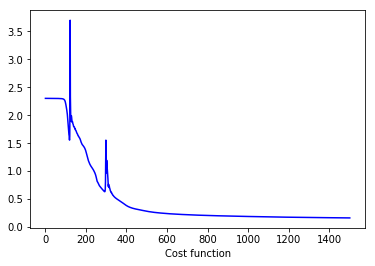

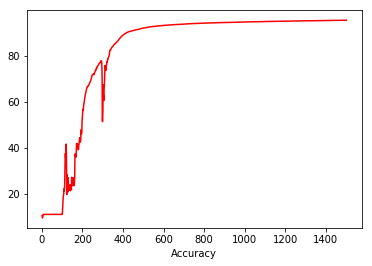

In [15]:
parameters, costs = main(train_data=train_data, train_labels=train_labels, iterations=1500, alpha=0.1, beta=0.9)
parameters_temp = parameters


In [19]:
accuracy_train, errors_train = get_accuracy(train_data, train_labels, parameters)
print(accuracy_train)
accuracy_test, errors_test = get_accuracy(test_data, test_labels, parameters)
print(accuracy_test)


95.28833333333333
93.94


In [ ]:
get_error(errors_test)

In [18]:
pickle.dump(parameters, open('trained_weights_mnist.p', 'wb'))